# An Introduction to conformal prediction


The aim of this notebook is to implement and better understand split conformal prediction, to understand the strenghts and limits of the guarantees.

0. Data Generation
1. Split conformal prediction  
  1.1. basic score function (absolute value of the residuals)  
  1.2. 'advanced' score function (locally weighted)  
  1.3. Conformal Quantile Regression (CQR)
2. Dependence of the coverage wrt the quality of the model
3. The coverage is on average on both the test point and the calibration set

# I- Data generation

We begin by generating a toy dataset, in which the data follow the distribution
$$
X \sim \mathrm{Beta}(6,3) \qquad Y| X \sim \cos(X) + (1-\cos(X))\mathcal{N}(0,0.5).
$$

In [ ]:
import random
import numpy as np
import scipy as sp
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_cal = colors_blindness[9]
color_test = colors_blindness[4]
np.random.seed(42)

In [ ]:
n_train = 100
n_cal = 100
n_test = 100
x_max, x_min = 0, 6 # For plotting limits

def sample_data(n):
    "Sample n data points from the given distribution"

    X = sp.stats.beta.rvs(a=6,b=3,loc=0,scale=6,size=n)

    ## Heteroscedastic model
    sigma = 0.5
    y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)
    return X, y

X_train, y_train = sample_data(n_train)
X_cal, y_cal = sample_data(n_cal)
X_test, y_test = sample_data(n_test)
X,y = np.vstack((X_train, X_cal, X_test)), np.hstack((y_train, y_cal, y_test))

x_max, x_min = np.max(np.vstack((X_train, X_cal, X_test))), np.min(np.vstack((X_train, X_cal, X_test)))


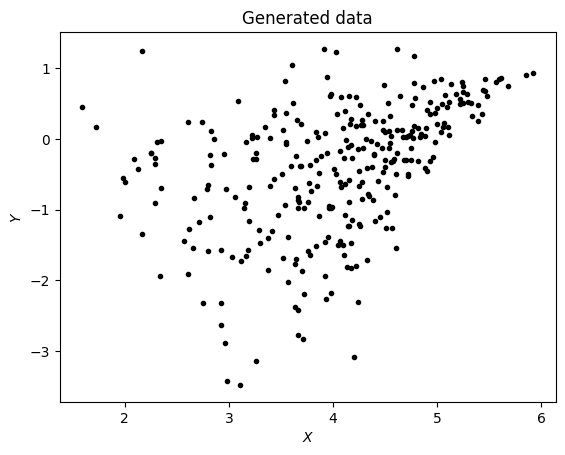

In [ ]:
plt.scatter(X,y,marker='.',color='black')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Generated data')
plt.show()

The data are randomly splitted into the train and test

# II- Split Conformal Prediction
## II.1- Regression model


We rely on a linear regression with polynomial features to fit the data.

**Q1 Complete the following implementation of the linear regression**


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


poly = PolynomialFeatures(4)
Xpoly_test = poly.fit_transform(X_test[:, np.newaxis])
Xpoly_train = poly.fit_transform(X_train[:, np.newaxis])
Xpoly_cal = poly.fit_transform(X_cal[:, np.newaxis])

linear_reg = linear_model.LinearRegression(fit_intercept=False)
linear_reg.fit(Xpoly_train,y_train) #TODO LINE

LinearRegression(fit_intercept=False)

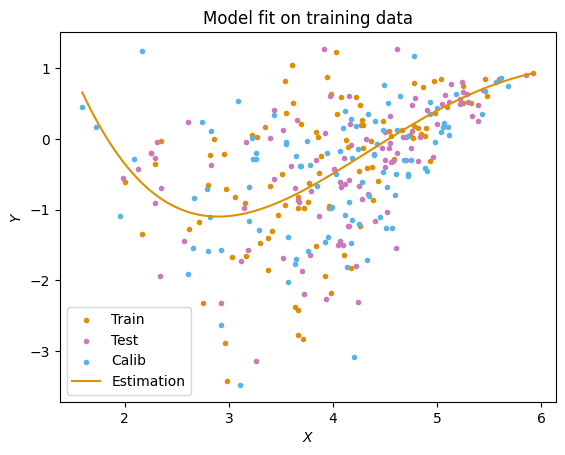

In [ ]:
# Visualization
plt.scatter(X_train,y_train,marker='.',color=color_train,label="Train")
plt.scatter(X_test,y_test,marker='.',color=color_test,label="Test")
plt.scatter(X_cal,y_cal,marker='.',color=color_cal,label="Calib")
aux = np.linspace(x_min,x_max,500)
auxpoly = poly.fit_transform(aux[:, np.newaxis])
plt.plot(aux,linear_reg.predict(auxpoly),color=color_train, label="Estimation")
plt.legend()
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Model fit on training data')
plt.show()

## II.2- Split Conformal Regression with basic scores

We begin by implementing the standard split conformal regression method

In [ ]:
alpha = 0.1 # We fix the coverage level for all the methods

**Q2 Complete the following cell to implement split conformal regression with the absolute error scores.**

In [ ]:
class ConformalRegressor:
    def __init__(self, model, alpha):
        self.model = model
        self.alpha = alpha

    def score_function(self, x, y):
        raise NotImplementedError("Score function must be implemented in subclass.")

    def fit(self, x_cal, y_cal):
        score_set = self.score_function(x_cal, y_cal) # TODO OPERAND
        self.q_hat = np.quantile(score_set, 1-self.alpha, method='higher') # TODO OPERAND

    def predict(self, x):
        """
        Returns lower and upper bounds of the prediction interval at covariate x
        """
        ## TODO BLOCK
        y_pred = self.model.predict(x)
        lower_bound = y_pred - self.q_hat
        upper_bound = y_pred + self.q_hat
        ## END TODO BLOCK
        return lower_bound, upper_bound

class StandardSCP(ConformalRegressor):
    def __init__(self, model, alpha):
        super().__init__(model, alpha)

    def score_function(self, x, y):
        y_pred = self.model.predict(x) # TODO OPERAND
        score = np.abs(y - y_pred) # TODO OPERAND
        return score



In [ ]:
standardSCP = StandardSCP(model=linear_reg, alpha=alpha)
standardSCP.fit(Xpoly_cal, y_cal)

Let's plot the resulting calibrated prediction interval.

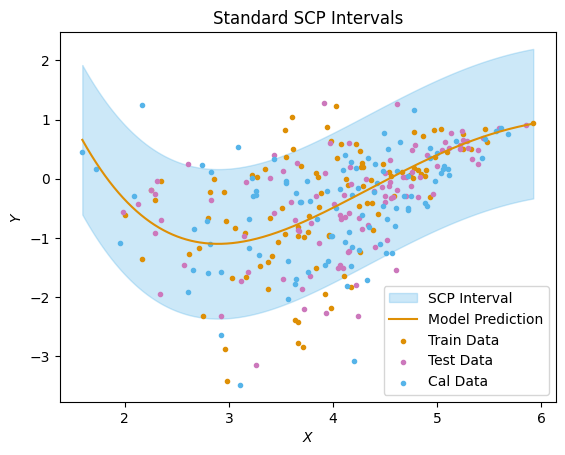

In [ ]:
aux = np.linspace(x_min,x_max,500)
auxpoly = poly.fit_transform(aux[:, np.newaxis])
lower_scp, upper_scp = standardSCP.predict(auxpoly)


plt.fill_between(aux, lower_scp, upper_scp, color=color_cal, alpha=0.3, label='SCP Interval')
plt.plot(aux, linear_reg.predict(auxpoly), color=color_train, label='Model Prediction')
plt.scatter(X_train, y_train, marker='.', color=color_train, label='Train Data')
plt.scatter(X_test, y_test, marker='.', color=color_test, label='Test Data')
plt.scatter(X_cal,y_cal,marker='.', color=color_cal, label='Cal Data')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Standard SCP Intervals')
plt.legend()
plt.show()

As we see, the interval lengths are independent of the covariate $X$. Thus, it can never capture the heteroskedasticity of the data.

## II.3- Locally Weighted Conformal Regression

Locally weighter conformal regression, studied for instance in [Lei et al (2018)](https://arxiv.org/pdf/1604.04173) p30 relies on both a regression model $\hat{\mu}(X)$, fitted on the training set, and an a model of the dispersion of the data $\hat{\sigma}(X)$, typically an estimate of the conditional mean absolute deviation (MAD) $\hat{\sigma}(X) \approx E[|Y - \hat{\mu}(x)| X]$, which is also fitted on the training set.

In this paradigm, the scores are adjusted by scaling it by $\hat{\sigma}(X)$:

$$R_i = \frac{|Y_i - \hat{\mu}(X_i)|}{\hat{\sigma(X_i)}}.$$

**Q3 Implement the Locally Weighted SCP Class, then fit a MAD (mean absolute deviation) model to the residual and fit the locally-weighted SCP method.**


In [ ]:
class LocallyWeightedSCP(ConformalRegressor):
    def __init__(self, model, model_mad, alpha):
        super().__init__(model, alpha)
        self.model_mad = model_mad

    def score_function(self, x, y):

        ### TODO BLOCK
        y_pred = self.model.predict(x)
        local_scale = self.model_mad.predict(x)
        local_scale = np.where(local_scale>0.0, local_scale, 1e-8)
        score = np.abs(y - y_pred) / local_scale
        ### END TODO BLOCK
        return score

    def predict(self, x):
        ### TODO BLOCK
        y_pred = self.model.predict(x)
        local_scale = self.model_mad.predict(x)
        local_scale = np.where(local_scale>0.0, local_scale, 1e-8)
        lower_bound = y_pred - self.q_hat*local_scale
        upper_bound = y_pred + self.q_hat*local_scale
        ### END TODO BLOCK
        return lower_bound, upper_bound

In [ ]:
# Estimation of the MAD with a Linear Regression on the residuals

mad_model = linear_model.LinearRegression(fit_intercept=False) # TODO OPERAND
residuals_train = np.abs(y_train - linear_reg.predict(Xpoly_train)) # TODO OPERAND
mad_model.fit(Xpoly_train, residuals_train)

weightedSCP = LocallyWeightedSCP(model=linear_reg, model_mad=mad_model, alpha=alpha) # TODO OPERAND
weightedSCP.fit(Xpoly_cal, y_cal)

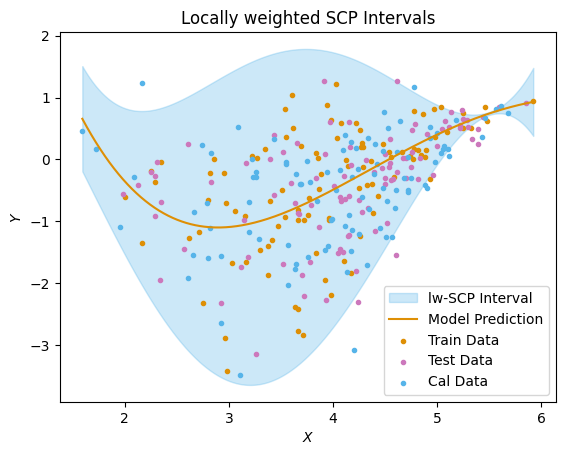

In [ ]:
# plotting the results

aux = np.linspace(x_min,x_max,500)
auxpoly = poly.fit_transform(aux[:, np.newaxis])
lower_lw_scp, upper_lw_scp = weightedSCP.predict(auxpoly)


plt.fill_between(aux, lower_lw_scp, upper_lw_scp, color=color_cal, alpha=0.3, label='lw-SCP Interval')
plt.plot(aux, linear_reg.predict(auxpoly), color=color_train, label='Model Prediction')
plt.scatter(X_train, y_train, marker='.', color=color_train, label='Train Data')
plt.scatter(X_test, y_test, marker='.', color=color_test, label='Test Data')
plt.scatter(X_cal, y_cal,marker='.', color=color_cal, label='Cal Data')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Locally weighted SCP Intervals')
plt.legend()
plt.show()

As highlighted in [Romano et al (2019)](https://proceedings.neurips.cc/paper_files/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf), training the estimating the MAD on the training set leads to a biased estimate,

Note, however, that since the MAD estimates are usually fit on the train residual, this gives a biased estimate which underestimates the error, which is compensated by on the train residual, this gives a biased estimate which under-estimate the error, which is compensated by the overly inflating the quantile of the score. Eventually, this leads generally to a less adaptive method than CQR.

## II.4- Conformal Quantile Regression (CQR)

CQR on the contrary relies on two model of the $1-\alpha/2$ and $\alpha$ quantile of the distribution, trained on the training set.

**Q4 Complete the following code to implement CQR, then fit it on the training and calibration set.**

In [ ]:

class ConformalQuantileRegressor(ConformalRegressor):
    def __init__(self, model_up, model_down, alpha):
        self.model_up = model_up
        self.model_down = model_down
        self.alpha = alpha

    def score_function(self, x, y):
        ### TODO BLOCK
        y_pred_up = self.model_up.predict(x)
        y_pred_down = self.model_down.predict(x)
        score = np.maximum(y - y_pred_up, y_pred_down - y)
        ### END TODO BLOCK
        return score

    def predict(self, x):
        ### TODO BLOCK
        y_pred_up = self.model_up.predict(x)
        y_pred_down = self.model_down.predict(x)
        lower_bound = y_pred_down - self.q_hat
        upper_bound = y_pred_up + self.q_hat
        ### END TODO BLOCK
        return lower_bound, upper_bound


In [ ]:
from sklearn.utils.fixes import sp_version, parse_version

## a good idea is to update scipy (!) to avoid problem of convergence
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

beta = alpha/2
qr_down = linear_model.QuantileRegressor(quantile=beta, alpha=0.0, solver='highs')
qr_up = linear_model.QuantileRegressor(quantile=1-beta, alpha=0.0, solver='highs')

# Fit Upper and Lower Quantile regression
qr_down.fit(Xpoly_train, y_train) #TODO LINE
qr_up.fit(Xpoly_train, y_train)   #TODO LINE

# Fit the conformal model on the calibration set
conformalQR = ConformalQuantileRegressor(model_up=qr_up, model_down=qr_down, alpha=alpha) # TODO OPERAND
conformalQR.fit(Xpoly_cal, y_cal)


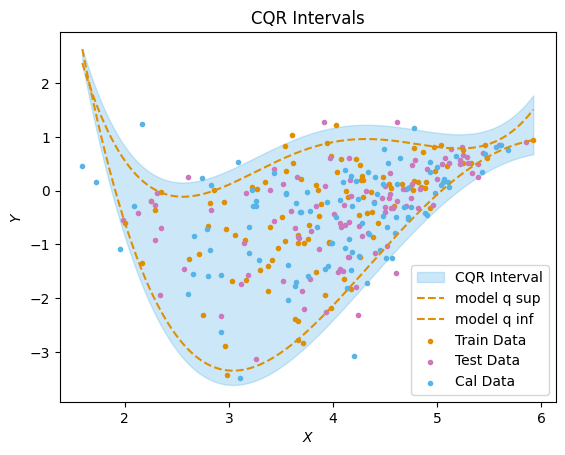

In [ ]:
# plotting the results

aux = np.linspace(x_min,x_max,500)
auxpoly = poly.fit_transform(aux[:, np.newaxis])
lower_cqr, upper_cqr = conformalQR.predict(auxpoly)
non_void = upper_cqr>lower_cqr # We check that when lower bound is less than the upper bound, otherwise the interval is empty


plt.fill_between(aux[non_void], lower_cqr[non_void], upper_cqr[non_void], color=color_cal, alpha=0.3, label='CQR Interval')
plt.plot(aux,qr_up.predict(auxpoly),'--',color=color_train,label="model q sup")
plt.plot(aux,qr_down.predict(auxpoly),'--',color=color_train,label="model q inf")
plt.scatter(X_train, y_train, marker='.', color=color_train, label='Train Data')
plt.scatter(X_test, y_test, marker='.', color=color_test, label='Test Data')
plt.scatter(X_cal, y_cal,marker='.', color=color_cal, label='Cal Data')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('CQR Intervals')
plt.legend()
plt.show()

# III- Estimation of the coverage
## III.1 - Do we have $P(Y_{n+1}\in \hat{C}_{\alpha}(X_{n+1})) \ge 1-\alpha$ ?

**Q. Estimate $P(Y_{n+1}\in \hat{C}_{\alpha}(X_{n+1}))$ for the three implemented methods, with asymptotic confidence interval**

Note that you can use the function 'sample_data' to generate fresh new samples.

In [ ]:
# TODO CELL

n_sim = 1000
seed = 42
rng = np.random.RandomState(seed)

coverages_per_testset = np.zeros(n_sim)
coverages_singlept = np.zeros(n_sim)

covering_scp = np.zeros(n_sim)
covering_scp_lw = np.zeros(n_sim)
covering_cqr = np.zeros(n_sim)

for i in range(n_sim):

    X_cal_sim, y_cal_sim = sample_data(n_cal)
    X_test_sim, y_test_sim = sample_data(1)

    Xpoly_cal_sim = poly.transform(X_cal_sim[:, np.newaxis])
    Xpoly_test_sim = poly.transform(X_test_sim[:, np.newaxis])

    standardSCP.fit(Xpoly_cal_sim, y_cal_sim)
    weightedSCP.fit(Xpoly_cal_sim, y_cal_sim)
    conformalQR.fit(Xpoly_cal_sim, y_cal_sim)

    lower_scp, upper_scp = standardSCP.predict(Xpoly_test_sim)
    lower_lw_scp, upper_lw_scp = weightedSCP.predict(Xpoly_test_sim)
    lower_cqr, upper_cqr = conformalQR.predict(Xpoly_test_sim)

    covering_scp[i] = ((lower_scp <= y_test_sim) * (y_test_sim <= upper_scp))[0]
    covering_scp_lw[i] = ((lower_lw_scp <= y_test_sim) * (y_test_sim <= upper_lw_scp))[0]
    covering_cqr[i] = ((lower_cqr <= y_test_sim) * (y_test_sim <= upper_cqr))[0]



print("Theoretical coverage: ",alpha)
print(f"Empirical coverage with SCP: {np.mean(covering_scp)} +/- {1.96*np.std(covering_scp,ddof=1)/np.sqrt(n_sim)} (IC 95%)")
print(f"Empirical coverage with lw-SCP: {np.mean(covering_scp_lw)} +/- {1.96*np.std(covering_scp_lw,ddof=1)/np.sqrt(n_sim)} (IC 95%)")
print(f"Empirical coverage with CQR: {np.mean(covering_cqr)} +/- {1.96*np.std(covering_cqr,ddof=1)/np.sqrt(n_sim)} (IC 95%)")

Theoretical coverage:  0.1
Empirical coverage with SCP: 0.889 +/- 0.019479853980744085 (IC 95%)
Empirical coverage with lw-SCP: 0.909 +/- 0.017835117095264662 (IC 95%)
Empirical coverage with CQR: 0.909 +/- 0.01783511709526466 (IC 95%)


## III.2- Fool's estimator

**Q Which quantity does the following code estimate ?**

In [ ]:
n_cal, n_test = 100,10000

X_cal_sim, y_cal_sim = sample_data(n_cal)
X_test_sim, y_test_sim = sample_data(n_test)

Xpoly_cal_sim = poly.transform(X_cal_sim[:, np.newaxis])
Xpoly_test_sim = poly.transform(X_test_sim[:, np.newaxis])

standardSCP.fit(Xpoly_cal_sim, y_cal_sim)
weightedSCP.fit(Xpoly_cal_sim, y_cal_sim)
conformalQR.fit(Xpoly_cal_sim, y_cal_sim)

lower_scp, upper_scp = standardSCP.predict(Xpoly_test_sim)
lower_lw_scp, upper_lw_scp = weightedSCP.predict(Xpoly_test_sim)
lower_cqr, upper_cqr = conformalQR.predict(Xpoly_test_sim)

coverage_scp = ((lower_scp<=y_test_sim)*(y_test_sim<=upper_scp))
coverage_lw_scp = ((lower_lw_scp<=y_test_sim)*(y_test_sim<=upper_lw_scp))
coverage_cqr = ((lower_cqr<=y_test_sim)*(y_test_sim<=upper_cqr))

# Print coverages
print("Theoretical coverage: ",alpha)
print(f"Empirical coverage SCP: {np.mean(coverage_scp)} +/- {1.96*np.std(coverage_scp,ddof=1)/np.sqrt(n_test)} (IC 95%)")
print(f"Empirical coverage lw-SCP: {np.mean(coverage_lw_scp)} +/- {1.96*np.std(coverage_lw_scp,ddof=1)/np.sqrt(n_test)} (IC 95%)")
print(f"Empirical coverage CQR: {np.mean(coverage_cqr)} +/- {1.96*np.std(coverage_cqr,ddof=1)/np.sqrt(n_test)} (IC 95%)")

Theoretical coverage:  0.1
Empirical coverage SCP: 0.887 +/- 0.006205529132892853 (IC 95%)
Empirical coverage lw-SCP: 0.8275 +/- 0.007405533282101921 (IC 95%)
Empirical coverage CQR: 0.8321 +/- 0.007326404555767548 (IC 95%)


## III.3 Distribution of the coverage conditionnal to the calibration set

Actually, what was previously estimated is
$$
P(Y_{n+1}\in \hat{C}_{\alpha}(X_{n+1})|(X_i,Y_i)_{i\in [n]}),
$$
which is not always greater that $1-\alpha$ !

Interestingly, as explained for instance in [[Angelopoulos et al.]]((https://arxiv.org/pdf/2107.07511)), this conditionnal distribution actually follows a well-known distribution:
$$
P(Y_{n+1}\in \hat{C}_{\alpha}(X_{n+1})|(X_i,Y_i)_{i\in [n]}) \sim Beta(k_{\alpha},n+1 - k_{\alpha}),
$$
with $k_{\alpha} = \lceil{(1-\alpha)(n+1)}\rceil$

**Q. Illustrate the distribution of the coverage conditionally on the calibration set, then see how it evolves with the size of the calibration set. Check that it matches the theory**

In [ ]:
def coverage_conditional_on_cal(n_cal, n_test, n_sim):
    """
    Sample n_sim calibration sets, for each, estimate the conditional coverage
    using a monte-carlo estimation with n_test samples.
    """
    coverage_scp = np.zeros(n_sim)
    coverage_lw_scp = np.zeros(n_sim)
    coverage_cqr = np.zeros(n_sim)
    # TODO BLOCK

    for i in range(n_sim):
        X_cal_sim, y_cal_sim = sample_data(n_cal)
        X_test_sim, y_test_sim = sample_data(n_test)

        Xpoly_cal_sim = poly.transform(X_cal_sim[:, np.newaxis])
        Xpoly_test_sim = poly.transform(X_test_sim[:, np.newaxis])

        standardSCP.fit(Xpoly_cal_sim, y_cal_sim)
        weightedSCP.fit(Xpoly_cal_sim, y_cal_sim)
        conformalQR.fit(Xpoly_cal_sim, y_cal_sim)

        lower_scp, upper_scp = standardSCP.predict(Xpoly_test_sim)
        lower_lw_scp, upper_lw_scp = weightedSCP.predict(Xpoly_test_sim)
        lower_cqr, upper_cqr = conformalQR.predict(Xpoly_test_sim)

        coverage_scp[i] = np.mean((lower_scp<=y_test_sim)*(y_test_sim<=upper_scp))
        coverage_lw_scp[i] = np.mean((lower_lw_scp<=y_test_sim)*(y_test_sim<=upper_lw_scp))
        coverage_cqr[i] = np.mean((lower_cqr<=y_test_sim)*(y_test_sim<=upper_cqr))
    # END TODO BLOCK
    return coverage_scp, coverage_lw_scp, coverage_cqr

n_sim = 5000
n_cal = 100
n_test = 20*n_cal
coverage_scp, coverage_lw_scp, coverage_cqr = coverage_conditional_on_cal(n_cal, n_test, n_sim)


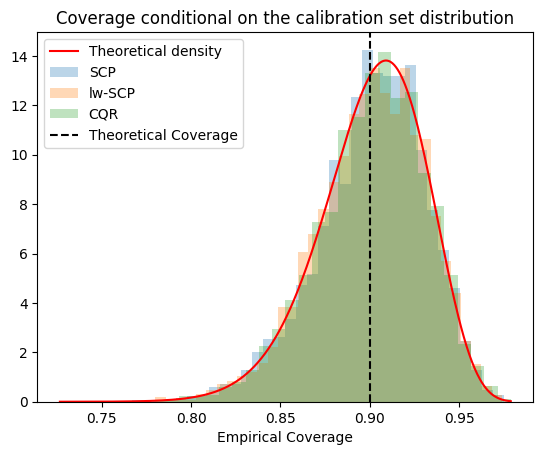

In [ ]:
# Plotting the results, and comparing it to the theoretical density

bins = int(n_sim**(1/3)*2)
x_min_cov,x_max_cov=np.min(coverage_cqr), np.max(coverage_cqr)
aux_x = np.linspace(x_min_cov,x_max_cov,500)

k_alpha =np.ceil((1-alpha)*(n_cal+1))
density_th = sp.stats.beta.pdf(aux_x, a=k_alpha, b=n_cal+1 - k_alpha)


plt.plot(aux_x,density_th, color='red',label='Theoretical density')
plt.hist(coverage_scp, bins=bins, label='SCP', alpha =0.3, density=True)
plt.hist(coverage_lw_scp, bins=bins, label='lw-SCP', alpha =0.3, density=True)
plt.hist(coverage_cqr, bins=bins, label='CQR', alpha =0.3, density=True)
plt.axvline(x=1-alpha, color='black', linestyle='--', label='Theoretical Coverage')
plt.xlabel('Empirical Coverage')
plt.legend()
plt.title('Coverage conditional on the calibration set distribution')
plt.show()

### What is happening when we increase/decrease the number of n_cal ?

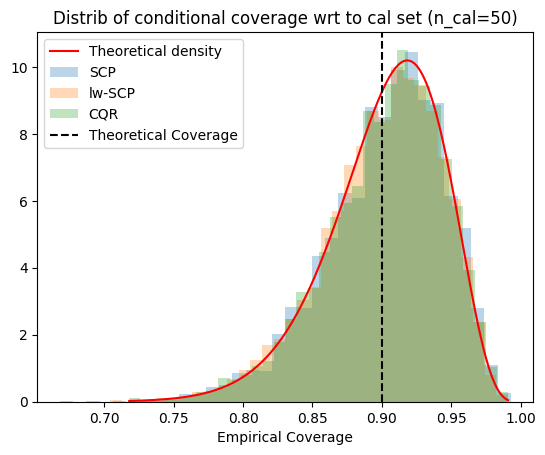

In [ ]:
n_sim = 5000

n_cal = 50

n_test = 20*n_cal
coverage_scp, coverage_lw_scp, coverage_cqr = coverage_conditional_on_cal(n_cal, n_test, n_sim)

# histograms of the coverages
bins = int(n_sim**(1/3)*2)
x_min_cov,x_max_cov=np.min(coverage_cqr), np.max(coverage_cqr)
aux_x = np.linspace(x_min_cov,x_max_cov,500)

k_alpha =np.ceil((1-alpha)*(n_cal+1))
density_th = sp.stats.beta.pdf(aux_x, a=k_alpha, b=n_cal+1 - k_alpha)


plt.plot(aux_x,density_th, color='red',label='Theoretical density')
plt.hist(coverage_scp, bins=bins, label='SCP', alpha =0.3, density=True)
plt.hist(coverage_lw_scp, bins=bins, label='lw-SCP', alpha =0.3, density=True)
plt.hist(coverage_cqr, bins=bins, label='CQR', alpha =0.3, density=True)
plt.axvline(x=1-alpha, color='black', linestyle='--', label='Theoretical Coverage')
plt.xlabel('Empirical Coverage')
plt.legend()
plt.title(f'Distrib of conditional coverage wrt to cal set (n_cal={n_cal})')
plt.show()

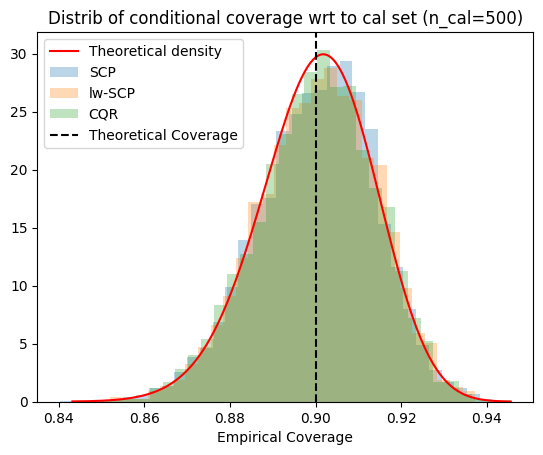

In [ ]:
n_sim = 5000

n_cal = 500

n_test = 20*n_cal
coverage_scp, coverage_lw_scp, coverage_cqr = coverage_conditional_on_cal(n_cal, n_test, n_sim)

# histograms of the coverages
bins = int(n_sim**(1/3)*2)
x_min_cov,x_max_cov=np.min(coverage_cqr), np.max(coverage_cqr)
aux_x = np.linspace(x_min_cov,x_max_cov,500)

k_alpha =np.ceil((1-alpha)*(n_cal+1))
density_th = sp.stats.beta.pdf(aux_x, a=k_alpha, b=n_cal+1 - k_alpha)


plt.plot(aux_x,density_th, color='red',label='Theoretical density')
plt.hist(coverage_scp, bins=bins, label='SCP', alpha =0.3, density=True)
plt.hist(coverage_lw_scp, bins=bins, label='lw-SCP', alpha =0.3, density=True)
plt.hist(coverage_cqr, bins=bins, label='CQR', alpha =0.3, density=True)
plt.axvline(x=1-alpha, color='black', linestyle='--', label='Theoretical Coverage')
plt.xlabel('Empirical Coverage')
plt.legend()
plt.title(f'Distrib of conditional coverage wrt to cal set (n_cal={n_cal})')
plt.show()